In [43]:
import tensorflow as tf

In [44]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

config.gpu_options.per_process_gpu_memory_fraction = 0.3

In [45]:
import os

In [46]:
import numpy as np
import random
import os

In [47]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"


DATA_PATH = 'C:/segmentation/datasets-promise12'
RESULT_PATH = 'C:/segmentation/result' 

In [48]:
def conv3d(input, filters, downsample=False, activation=True, batch_norm=False):
    if downsample: strides = [1,2,2,2,1]
    else: strides = [1,1,1,1,1]
    y = tf.nn.conv3d(input, filters, strides=strides, padding='SAME')
    if batch_norm: y = batch_norm(y)
    if activation: y = tf.nn.relu(y)
    return y  # where bn can be added

In [49]:
def resnet_block(input, filters, batch_norm=False):
    y = conv3d(input, filters[..., 0])
    y = conv3d(y, filters[..., 1], activation=False) + input
    if batch_norm: y = batch_norm(y)
    return tf.nn.relu(y)  # where bn can be added

In [50]:
def downsample_maxpool(input, filters):
    y = conv3d(input, filters)
    return tf.nn.max_pool3d(y, ksize=[1,3,3,3,1], padding='SAME', strides=[1,2,2,2,1])

In [51]:
def deconv3d(input, filters, out_shape, batch_norm=False):
    y = tf.nn.conv3d_transpose(input, filters, output_shape=out_shape, strides=[1,2,2,2,1], padding='SAME') 
    if batch_norm: y = batch_norm(y)
    return tf.nn.relu(y)  # where bn can be added

In [52]:
def batch_norm(inputs, is_training, decay = 0.999):
    # This is where to insert the implementation of batch normalisaiton
    return inputs

In [53]:
def add_variable(var_shape, var_list, var_name=None, initialiser=None):
    if initialiser is None:
        initialiser = tf.initializers.glorot_normal()
    if var_name is None:
        var_name = 'var{}'.format(len(var_list))
        var_list.append(tf.Variable(initialiser(var_shape), name=var_name, trainable=True))
    return var_list

In [54]:
### Define a model (the 3D U-Net) with residual layers
### ref: https://arxiv.org/abs/1512.03385  & https://arxiv.org/abs/1505.04597
## define all the trinable weights
num_channels = 32
nc = [num_channels*(2**i) for i in range(4)]
var_list=[]
# intial-layer
var_list = add_variable([5,5,5,1,nc[0]], var_list)
# encoder-s0
var_list = add_variable([3,3,3,nc[0],nc[0],2], var_list)
var_list = add_variable([3,3,3,nc[0],nc[0],2], var_list)
var_list = add_variable([3,3,3,nc[0],nc[0]], var_list)
var_list = add_variable([3,3,3,nc[0],nc[1]], var_list)
# encoder-s1
var_list = add_variable([3,3,3,nc[1],nc[1],2], var_list)
var_list = add_variable([3,3,3,nc[1],nc[1],2], var_list)
var_list = add_variable([3,3,3,nc[1],nc[1]], var_list)
var_list = add_variable([3,3,3,nc[1],nc[2]], var_list)
# encoder-s2
#var_list = add_variable([3,3,3,nc[2],nc[2],2], var_list)
#var_list = add_variable([3,3,3,nc[2],nc[2],2], var_list)
#var_list = add_variable([3,3,3,nc[2],nc[2]], var_list)
#var_list = add_variable([3,3,3,nc[2],nc[3]], var_list)
# deep-layers-s3
#var_list = add_variable([3,3,3,nc[3],nc[3],2], var_list)
#var_list = add_variable([3,3,3,nc[3],nc[3],2], var_list)
#var_list = add_variable([3,3,3,nc[3],nc[3],2], var_list)

var_list = add_variable([3,3,3,nc[2],nc[2],2], var_list)
var_list = add_variable([3,3,3,nc[2],nc[2],2], var_list)
var_list = add_variable([3,3,3,nc[2],nc[2],2], var_list)
# decoder-s2
#var_list = add_variable([3,3,3,nc[2],nc[3]], var_list)
#var_list = add_variable([3,3,3,nc[2],nc[2],2], var_list)
#var_list = add_variable([3,3,3,nc[2],nc[2],2], var_list)
# decoder-s1
var_list = add_variable([3,3,3,nc[1],nc[2]], var_list)
var_list = add_variable([3,3,3,nc[1],nc[1],2], var_list)
var_list = add_variable([3,3,3,nc[1],nc[1],2], var_list)
# decoder-s0
var_list = add_variable([3,3,3,nc[0],nc[1]], var_list)
var_list = add_variable([3,3,3,nc[0],nc[0],2], var_list)
var_list = add_variable([3,3,3,nc[0],nc[0],2], var_list)
# output-layer
var_list = add_variable([3,3,3,nc[0],1], var_list)

## model with corresponding layers
@tf.function
def residual_unet(input):
    # initial-layer
    skip_layers = []
    layer = conv3d(input, var_list[0])
    # encoder-s0
    layer = resnet_block(layer, var_list[1])
    layer = resnet_block(layer, var_list[2])
    skip_layers.append(layer)
    layer = downsample_maxpool(layer, var_list[3])
    layer = conv3d(layer, var_list[4])
    # encoder-s1
    layer = resnet_block(layer, var_list[5])
    layer = resnet_block(layer, var_list[6])
    skip_layers.append(layer)
    layer = downsample_maxpool(layer, var_list[7])
    layer = conv3d(layer, var_list[8])
    # encoder-s2
    #layer = resnet_block(layer, var_list[9])
    #layer = resnet_block(layer, var_list[10])
    #skip_layers.append(layer)
    #layer = downsample_maxpool(layer, var_list[11])
    #layer = conv3d(layer, var_list[12])
    # deep-layers-s3
    #layer = resnet_block(layer, var_list[13])
    #layer = resnet_block(layer, var_list[14])
    #layer = resnet_block(layer, var_list[15])
    layer = resnet_block(layer, var_list[9])
    layer = resnet_block(layer, var_list[10])
    layer = resnet_block(layer, var_list[11])
    # decoder-s2
    #layer = deconv3d(layer, var_list[16], skip_layers[2].shape) + skip_layers[2]
    #layer = resnet_block(layer, var_list[17])
    #layer = resnet_block(layer, var_list[18])
    # decoder-s1
    layer = deconv3d(layer, var_list[12], skip_layers[1].shape) + skip_layers[1]
    layer = resnet_block(layer, var_list[13])
    layer = resnet_block(layer, var_list[14])
    # decoder-s0
    layer = deconv3d(layer, var_list[15], skip_layers[0].shape) + skip_layers[0]
    layer = resnet_block(layer, var_list[16])
    layer = resnet_block(layer, var_list[17])
    # output-layer
    layer = tf.sigmoid(conv3d(layer, var_list[18], activation=False))
    return layer

In [55]:
def loss_crossentropy(pred, target):
    return tf.losses.BinaryCrossentropy(pred=pred, target=target)

def loss_dice(pred, target, eps=1e-6):
    dice_numerator = 2 * tf.reduce_sum(pred*target, axis=[1,2,3,4])
    dice_denominator = eps + tf.reduce_sum(pred, axis=[1,2,3,4]) + tf.reduce_sum(target, axis=[1,2,3,4])
    return  1 - tf.reduce_mean(dice_numerator/dice_denominator)

In [56]:
### a simple npy image reading class
class DataReader:
    def __init__(self, folder_name):
        self.folder_name = folder_name
    def load_images_train(self, indices_mb):
        return self.load_npy_files(["image_train%02d.npy" % idx for idx in indices_mb])
    def load_images_test(self, indices_mb):
        return self.load_npy_files(["image_test%02d.npy" % idx for idx in indices_mb])
    def load_labels_train(self, indices_mb):
        return self.load_npy_files(["label_train%02d.npy" % idx for idx in indices_mb])
    def load_npy_files(self, file_names):
        images = [np.float32(np.load(os.path.join(self.folder_name, fn))) for fn in file_names]
        return np.expand_dims(np.stack(images, axis=0), axis=4)

In [ ]:
### training
@tf.function
def train_step(model, weights, optimizer, x, y):
    with tf.GradientTape() as tape:
        # g_tape.watched(var_list): trainable variables are automatically "watched".
        loss = loss_dice(model(x), y)
    gradients = tape.gradient(loss, weights)
    optimizer.apply_gradients(zip(gradients, weights))
    return loss
learning_rate = 1e-5
total_iter = int(3.2e3)
n = 50  # 50 training image-label pairs
size_minibatch = 4

num_minibatch = int(n/size_minibatch)  # how many minibatches in each epoch
indices_train = [i for i in range(n)]

DataFeeder = DataReader(DATA_PATH)
optimizer = tf.optimizers.Adam(learning_rate)
ckpt = tf.train.Checkpoint(optimizer=optimizer, net=residual_unet)
manager = tf.train.CheckpointManager(ckpt, 'C:/segmentation/tf_ckpts', max_to_keep=3)
status = ckpt.restore(manager.latest_checkpoint)

for step in range(total_iter):

    # shuffle data every time start a new set of minibatches
    if step in range(0, total_iter, num_minibatch):
        random.shuffle(indices_train)

    # find out data indices for a minibatch
    minibatch_idx = step % num_minibatch  # minibatch index
    indices_mb = indices_train[minibatch_idx*size_minibatch:(minibatch_idx+1)*size_minibatch]
    # halve image size so this can be reasonably tested, e.g. on a CPU
    input_mb = DataFeeder.load_images_train(indices_mb)[:, ::2, ::2, ::2, :]
    label_mb = DataFeeder.load_labels_train(indices_mb)[:, ::2, ::2, ::2, :]
    # update the variables
    loss_train = train_step(residual_unet, var_list, optimizer, input_mb, label_mb)
    #loss_val = loss_dice()

    # print training information
    if (step % 100) == 0:
        tf.print('Step', step, ': training-loss=', loss_train)

    # --- simple tests during training ---
    if (step % 1000) == 0:
        indices_test = [random.randrange(30) for i in range(size_minibatch)]  # select size_minibatch test data
        input_test = DataFeeder.load_images_test(indices_test)[:, ::2, ::2, ::2, :]
        pred_test = residual_unet(input_test)
        # save the segmentation
        for idx in range(size_minibatch):
            np.save(os.path.join(RESULT_PATH, "label_test%02d_step%06d.npy" % (indices_test[idx], step)), pred_test[idx, ...])
        tf.print('Test results saved.')
        manager.save()

Step 0 : training-loss= 0.999847591
Test results saved.
Step 100 : training-loss= 0.558732033
Step 200 : training-loss= 0.271357775
Step 300 : training-loss= 0.301102519
Step 400 : training-loss= 0.313835979
Step 500 : training-loss= 0.18778342
Step 600 : training-loss= 0.214920759
Step 700 : training-loss= 0.201678157
Step 800 : training-loss= 0.17959094
Step 900 : training-loss= 0.161494732
Step 1000 : training-loss= 0.180199504
Test results saved.


In [16]:
input_test = DataFeeder.load_images_test(indices_test)[:, ::2, ::2, ::2, :]
pred_test = residual_unet(input_test)
plt.imshow([[1,1,1],[0,1,0],[1,1,1]])

NameError: name 'plt' is not defined

In [17]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [18]:
slices_to_plot = [2,5,8,11,14]  # must be smaller than total number of slices

Label loaded: C:/segmentation/result\label_test00_step000000.npy.
(16, 64, 64)


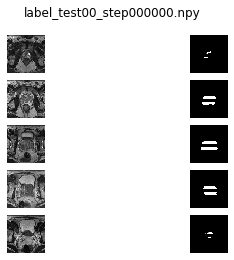

Label loaded: C:/segmentation/result\label_test01_step000000.npy.
(16, 64, 64)


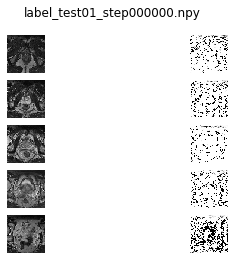

Label loaded: C:/segmentation/result\label_test01_step003000.npy.
(16, 64, 64)


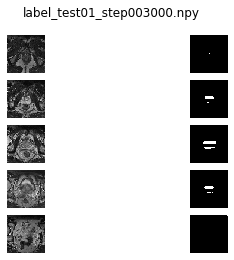

Label loaded: C:/segmentation/result\label_test02_step000000.npy.
(16, 64, 64)


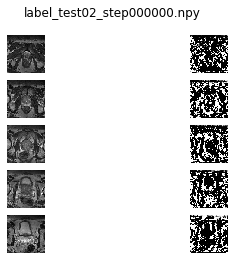

Label loaded: C:/segmentation/result\label_test02_step001000.npy.
(16, 64, 64)


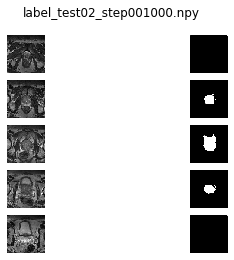

Label loaded: C:/segmentation/result\label_test03_step000000.npy.
(16, 64, 64)


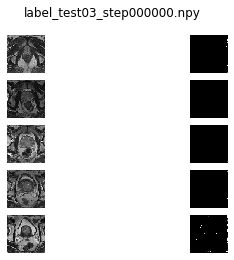

Label loaded: C:/segmentation/result\label_test03_step001000.npy.
(16, 64, 64)


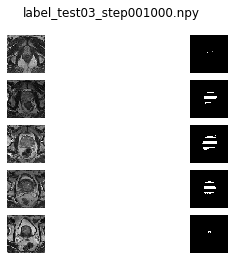

Label loaded: C:/segmentation/result\label_test04_step001000.npy.
(16, 64, 64)


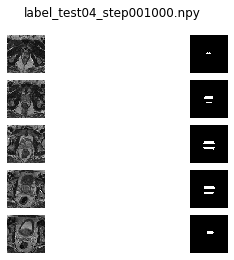

Label loaded: C:/segmentation/result\label_test04_step003000.npy.
(16, 64, 64)


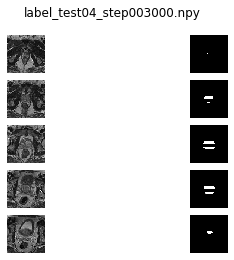

Label loaded: C:/segmentation/result\label_test05_step000000.npy.
(16, 64, 64)


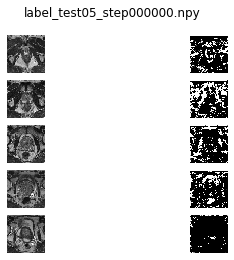

Label loaded: C:/segmentation/result\label_test05_step002000.npy.
(16, 64, 64)


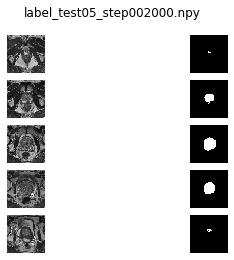

Label loaded: C:/segmentation/result\label_test05_step003000.npy.
(16, 64, 64)


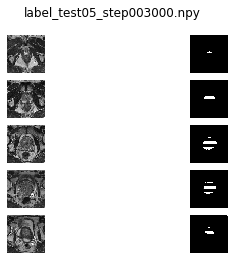

Label loaded: C:/segmentation/result\label_test06_step000000.npy.
(16, 64, 64)


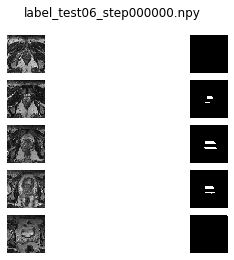

Label loaded: C:/segmentation/result\label_test07_step000000.npy.
(16, 64, 64)


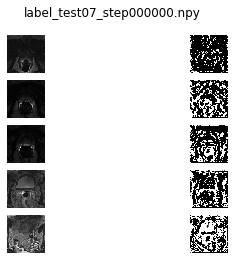

Label loaded: C:/segmentation/result\label_test07_step001000.npy.
(16, 64, 64)


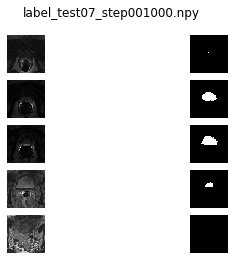

Label loaded: C:/segmentation/result\label_test07_step002000.npy.
(16, 64, 64)


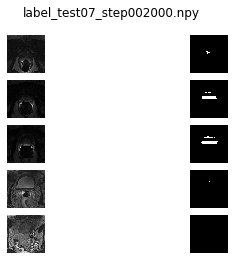

Label loaded: C:/segmentation/result\label_test07_step003000.npy.
(16, 64, 64)


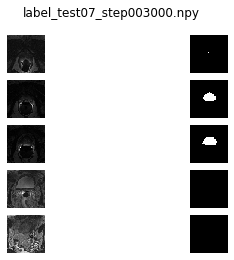

Label loaded: C:/segmentation/result\label_test09_step000000.npy.
(16, 64, 64)


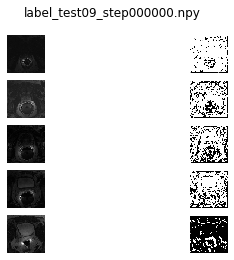

Label loaded: C:/segmentation/result\label_test10_step000000.npy.
(16, 64, 64)


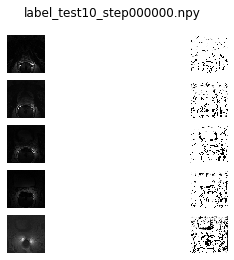

Label loaded: C:/segmentation/result\label_test11_step002000.npy.
(16, 64, 64)


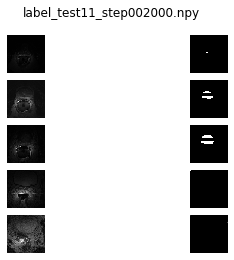

Label loaded: C:/segmentation/result\label_test12_step000000.npy.
(16, 64, 64)


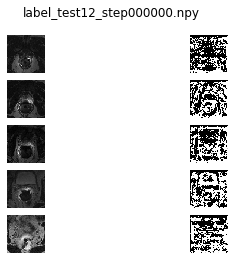

Label loaded: C:/segmentation/result\label_test12_step001000.npy.
(16, 64, 64)


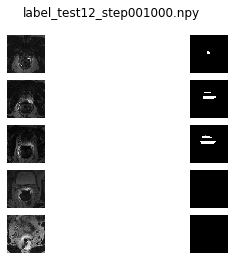

Label loaded: C:/segmentation/result\label_test12_step002000.npy.
(16, 64, 64)


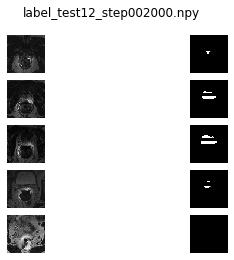

Label loaded: C:/segmentation/result\label_test13_step000000.npy.
(16, 64, 64)


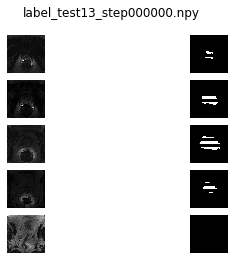

Label loaded: C:/segmentation/result\label_test13_step002000.npy.
(16, 64, 64)


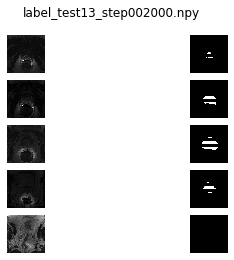

Label loaded: C:/segmentation/result\label_test14_step000000.npy.
(16, 64, 64)


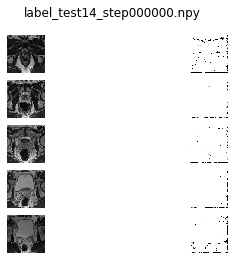

Label loaded: C:/segmentation/result\label_test14_step001000.npy.
(16, 64, 64)


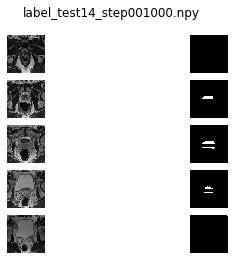

Label loaded: C:/segmentation/result\label_test15_step000000.npy.
(16, 64, 64)


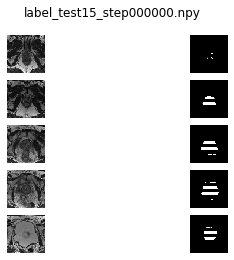

Label loaded: C:/segmentation/result\label_test15_step002000.npy.
(16, 64, 64)


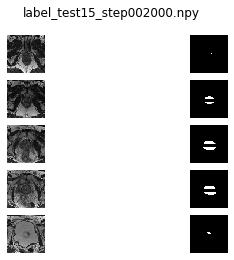

Label loaded: C:/segmentation/result\label_test16_step000000.npy.
(16, 64, 64)


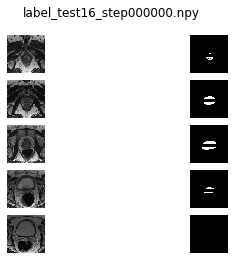

Label loaded: C:/segmentation/result\label_test17_step000000.npy.
(16, 64, 64)


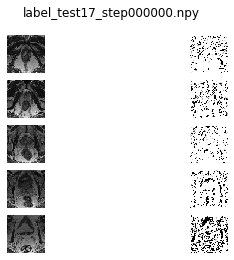

Label loaded: C:/segmentation/result\label_test17_step002000.npy.
(16, 64, 64)


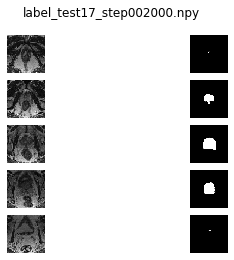

Label loaded: C:/segmentation/result\label_test17_step003000.npy.
(16, 64, 64)


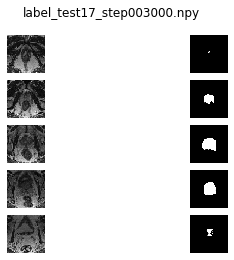

Label loaded: C:/segmentation/result\label_test19_step000000.npy.
(16, 64, 64)


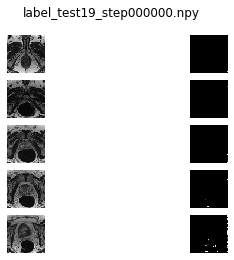

Label loaded: C:/segmentation/result\label_test19_step001000.npy.
(16, 64, 64)


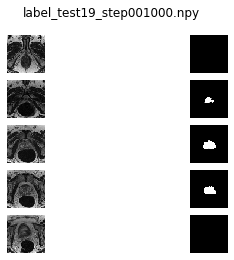

Label loaded: C:/segmentation/result\label_test19_step003000.npy.
(16, 64, 64)


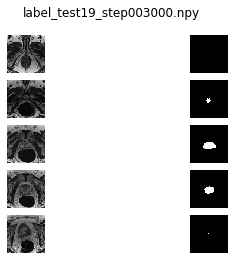

Label loaded: C:/segmentation/result\label_test21_step001000.npy.
(16, 64, 64)


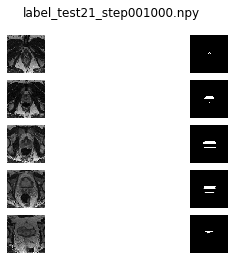

Label loaded: C:/segmentation/result\label_test22_step000000.npy.
(16, 64, 64)


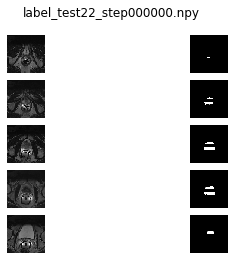

Label loaded: C:/segmentation/result\label_test22_step001000.npy.
(16, 64, 64)


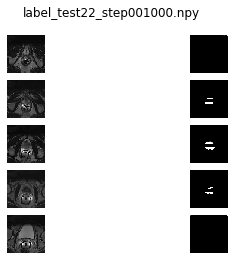

Label loaded: C:/segmentation/result\label_test22_step002000.npy.
(16, 64, 64)


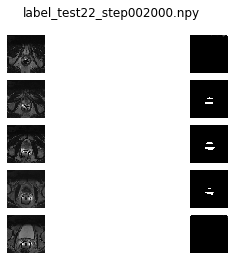

Label loaded: C:/segmentation/result\label_test24_step000000.npy.
(16, 64, 64)


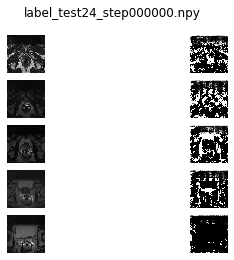

Label loaded: C:/segmentation/result\label_test25_step000000.npy.
(16, 64, 64)


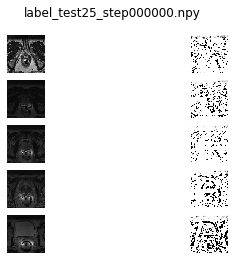

Label loaded: C:/segmentation/result\label_test26_step000000.npy.
(16, 64, 64)


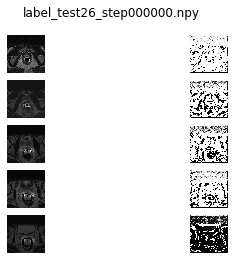

Label loaded: C:/segmentation/result\label_test26_step002000.npy.
(16, 64, 64)


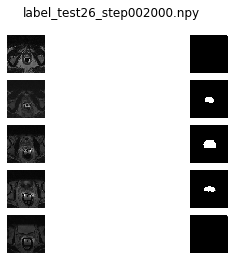

Label loaded: C:/segmentation/result\label_test26_step003000.npy.
(16, 64, 64)


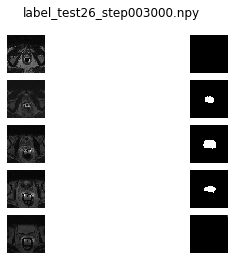

Label loaded: C:/segmentation/result\label_test27_step000000.npy.
(16, 64, 64)


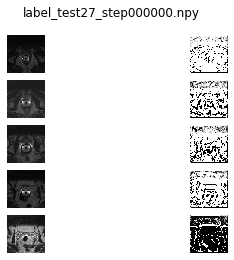

Label loaded: C:/segmentation/result\label_test27_step001000.npy.
(16, 64, 64)


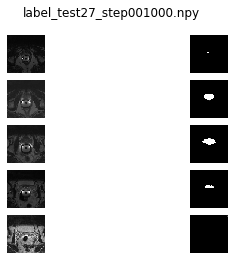

Label loaded: C:/segmentation/result\label_test28_step002000.npy.
(16, 64, 64)


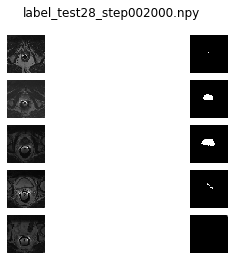

Label loaded: C:/segmentation/result\label_test29_step000000.npy.
(16, 64, 64)


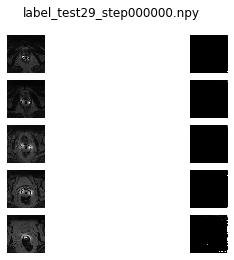

In [19]:
# find all the available results
for filename in os.listdir(RESULT_PATH):
    if filename.endswith(".npy"):
        print('Label loaded: %s.' % os.path.join(RESULT_PATH, filename))
        label = np.load(os.path.join(RESULT_PATH, filename))[..., 0]
        image = np.load(os.path.join(DATA_PATH, "image_"+filename.split('_')[1]+".npy"))[::2, ::2, ::2]
        print(label.shape)
        plt.figure()
        plt.suptitle(filename)
        for idx in range(len(slices_to_plot)):
            axs = plt.subplot(len(slices_to_plot),2,idx*2+1)
            axs.imshow(image[slices_to_plot[idx],:,:], cmap='gray')
            axs.axis('off')
            axs = plt.subplot(len(slices_to_plot),2,idx*2+2)
            axs.imshow(label[slices_to_plot[idx],:,:], cmap='gray')
            axs.axis('off')
        plt.ion()
        plt.show()

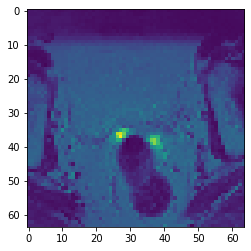

In [31]:
plt.imshow(image[15])

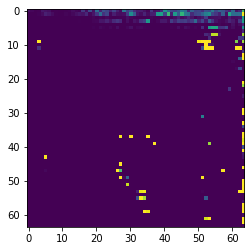

In [34]:
plt.imshow(label[15])

In [35]:
label = np.load('C:/segmentation/result/label_test07_step003000.npy')[..., 0] 

In [37]:
label.shape

(16, 64, 64)

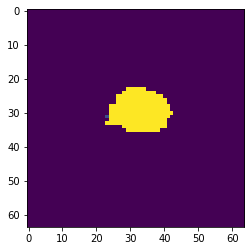

In [39]:
plt.imshow(label[4])

In [40]:
label[4].shape

(64, 64)

In [41]:
# indices_test = [random.randrange(30) for i in range(size_minibatch)]  # select size_minibatch test data
input_test = DataFeeder.load_images_test(indices_test)[:, ::2, ::2, ::2, :]
pred_test = residual_unet(input_test)

In [52]:
input_test

array([[[[[ 8.870e+02],
          [ 1.009e+03],
          [ 9.860e+02],
          ...,
          [ 2.420e+02],
          [ 7.330e+02],
          [ 8.770e+02]],

         [[ 7.200e+02],
          [ 4.900e+02],
          [ 5.860e+02],
          ...,
          [ 9.340e+02],
          [ 9.330e+02],
          [ 9.840e+02]],

         [[ 8.850e+02],
          [ 2.550e+02],
          [ 3.540e+02],
          ...,
          [ 9.670e+02],
          [ 1.116e+03],
          [ 8.950e+02]],

         ...,

         [[ 3.000e+02],
          [ 3.340e+02],
          [ 3.220e+02],
          ...,
          [ 3.470e+02],
          [ 3.410e+02],
          [ 2.790e+02]],

         [[ 3.610e+02],
          [ 2.910e+02],
          [ 2.400e+02],
          ...,
          [ 3.700e+02],
          [ 3.290e+02],
          [ 3.300e+02]],

         [[ 2.420e+02],
          [ 3.650e+02],
          [ 3.430e+02],
          ...,
          [ 6.990e+02],
          [ 4.520e+02],
          [ 4.700e+02]]],


        [[[ 6.220

In [51]:
pred_test[:, ::2, ::2, ::2, :]

<tf.Tensor: id=12711, shape=(4, 8, 32, 32, 1), dtype=float32, numpy=
array([[[[[0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00],
          ...,
          [0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00]],

         [[0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00],
          ...,
          [0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00]],

         [[0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00],
          ...,
          [0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00]],

         ...,

         [[0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00],
          ...,
          [0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00]],

         [[0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00],
          ...,
          [0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00]],

         [[0.0000000e

In [53]:
DataFeeder = DataReader(DATA_PATH)

In [54]:
DataFeeder

In [56]:
input_test = DataFeeder.load_images_test(indices_test)[:, ::2, ::2, ::2, :]

In [57]:
indices_test

[7, 17, 26, 19]

In [59]:
input_test.shape

(4, 16, 64, 64, 1)

In [64]:
input_test[1][1].shape

(64, 64, 1)

In [84]:
input_test = DataFeeder.load_images_test([2])[:, ::2, ::2, ::2, :]

In [85]:
input_test.shape

(1, 16, 64, 64, 1)

In [86]:
pred_test = residual_unet(input_test)

In [87]:
pred_test.shape

TensorShape([1, 16, 64, 64, 1])

In [92]:
idx

4

In [91]:
pred_test[idx, ...]

InvalidArgumentError: slice index 4 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

In [93]:
np.save(os.path.join(RESULT_PATH, "label_test%02d_step%06d.npy" % (indices_test[idx], step)), pred_test[idx, ...])

IndexError: list index out of range